# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [Titanic RAMP](http://www.ramp.studio/problems/titanic): survival prediction of Titanic passengers

## Introduction
This is an initiation project to introduce RAMP and get you to know how it works.

The goal is to develop prediction models able to **identify people who survived from the sinking of the Titanic, based on gender, age, and ticketing information**. 

The data we will manipulate is from the [Titanic kaggle challenge](https://www.kaggle.com/c/titanic-gettingStarted).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Exploratory data analysis

### Loading the data

We can use some utilities from RAMP to load the public train and test sets.

In [2]:
import problem

In [3]:
X_train, y_train = problem.get_train_data()

`X_train` contains information about each person which has a ticket to go on the boat while `y_train` is the information if a passenger survived or did not.

In [4]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S
1,2,"Beane, Mr. Edward",male,32.0,1,0,2908,26.000,NaN,S
2,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.075,NaN,S
3,3,"Torber, Mr. Ernst William",male,44.0,0,0,364511,8.050,NaN,S
4,2,"Bystrom, Mrs. (Karolina)",female,42.0,0,0,236852,13.000,NaN,S


In [5]:
y_train[:5]

array([0, 1, 0, 0, 1])

We can first look at some descriptive statistics regarding our data.

In [6]:
X_train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,356.000000,290.000000,356.000000,356.000000,356.000000
mean,2.300562,29.123862,0.550562,0.412921,31.657970
std,0.833861,14.103122,1.120978,0.798415,43.474154
min,1.000000,0.920000,0.000000,0.000000,0.000000
25%,2.000000,19.000000,0.000000,0.000000,7.925000
50%,3.000000,28.000000,0.000000,0.000000,15.245800
75%,3.000000,37.000000,1.000000,1.000000,31.275000
max,3.000000,71.000000,8.000000,6.000000,263.000000


Then, this is good to have an overlook regarding the type of data, we are dealing with and if there is any missing value.

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    356 non-null    int64  
 1   Name      356 non-null    object 
 2   Sex       356 non-null    object 
 3   Age       290 non-null    float64
 4   SibSp     356 non-null    int64  
 5   Parch     356 non-null    int64  
 6   Ticket    356 non-null    object 
 7   Fare      356 non-null    float64
 8   Cabin     83 non-null     object 
 9   Embarked  356 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 27.9+ KB


The original training data frame has 891 rows. In the starting kit, we give you a subset of 356 rows. Some passengers have missing information: in particular `Age` and `Cabin` info can be missing. The meaning of the columns is explained on the [challenge website](https://www.kaggle.com/c/titanic-gettingStarted/data).

### Predicting survival

The goal is to predict whether a passenger has survived from other known attributes. Let us group the data according to the `Survived` columns:

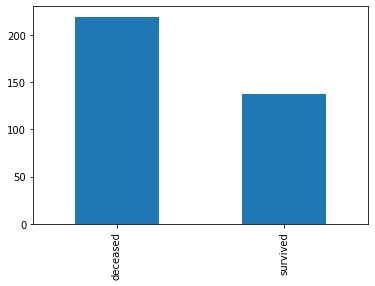

In [8]:
_ = pd.Series(y_train).value_counts().rename({0: "deceased", 1: "survived"}).plot(kind="bar")

About two thirds of the passengers perished in the event. A dummy classifier that systematically returns "0" would have an accuracy of 62%, higher than that of a random model.

### Some plots

#### Features densities and co-evolution
A scatterplot matrix allows us to visualize:
* on the diagonal, the density estimation for each feature
* on each of the off-diagonal plots, a scatterplot between two features. Each dot represents an instance.

In [9]:
df = X_train.copy()
df["Survived"] = y_train

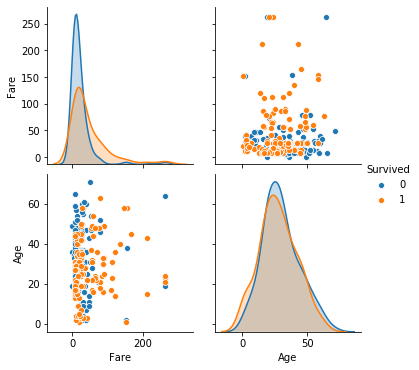

In [10]:
features = ['Fare', 'Age', 'Survived']
_ = sns.pairplot(
    df[features], hue="Survived"
)

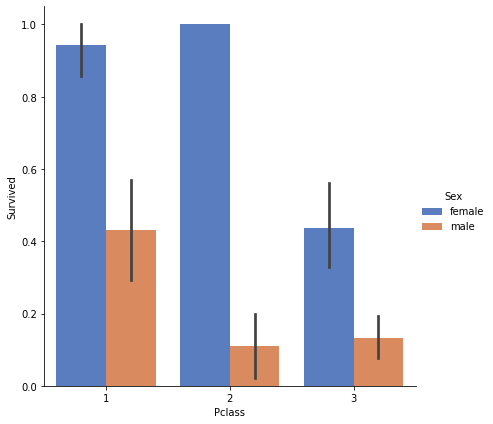

In [11]:
g = sns.catplot(
    x="Pclass", y="Survived", hue="Sex", data=df,
    height=6, kind="bar", palette="muted"
)

#### Non-linearly transformed data

The `Fare` variable has a very heavy tail. We can log-transform it. 

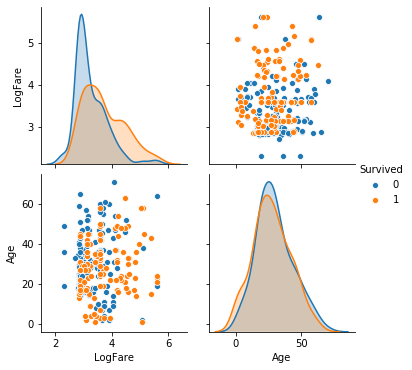

In [12]:
df["LogFare"] = np.log(df["Fare"] + 10)
features = ['LogFare', 'Age', 'Survived']
_ = sns.pairplot(
    df[features], hue="Survived"
)

#### Plot the bivariate distributions and marginals of two variables 

Another way of visualizing relationships between variables is to plot their bivariate distributions.

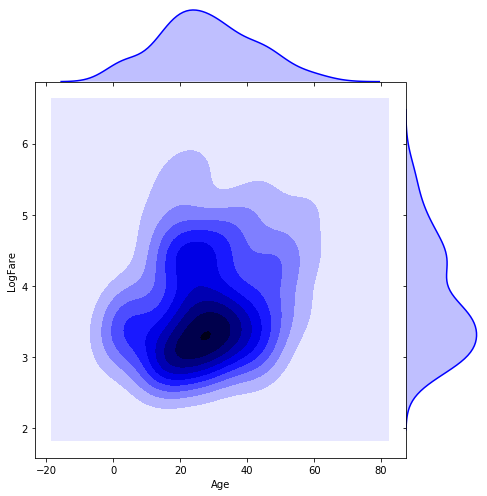

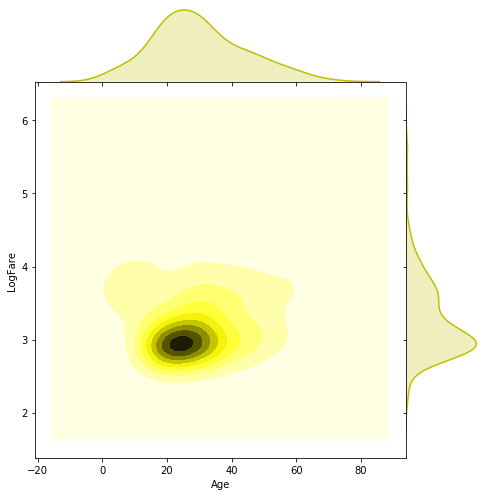

In [13]:
_ = sns.jointplot(
    df.Age[df.Survived == 1],
    df.LogFare[df.Survived == 1],
    kind="kde", height=7, space=0, color="b"
)

_ = sns.jointplot(
    df.Age[df.Survived == 0],
    df.LogFare[df.Survived == 0],
    kind="kde", height=7, space=0, color="y"
)

## Making predictions

A basic prediction workflow, using scikit-learn, will be presented below.

First, we will perform some simple preprocessing of our data:

* [one-hot encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) the categorical features: `Sex`, `Pclass`, `Embarked`
* for the numerical columns `Age`, `SibSp`, `Parch`, `Fare`, fill in missing values with a default value (`-1`)
* all remaining columns will be dropped

This can be done succintly with [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) which performs specific transformations on specific features.

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

categorical_cols = ['Sex', 'Pclass', 'Embarked']
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']
numerical_pipeline = make_pipeline(
    StandardScaler(), SimpleImputer(strategy='constant', fill_value=-1)
)

preprocessor = make_column_transformer(
    (categorical_pipeline, categorical_cols),
    (numerical_pipeline, numerical_cols),
)

The `preprocessor` object created with `make_column_transformer` can be used in a scikit-learn [`pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). A `pipeline` assembles several steps together and can be used to cross validate an entire workflow. Generally, transformation steps are combined with a final estimator.

We will create a pipeline consisting of the `preprocessor` created above and a final estimator, `LogisticRegression`.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('transformer', preprocessor),
    ('classifier', LogisticRegression()),
])

We can cross-validate our `pipeline` using `cross_val_score`. Below we will have specified `cv=8` meaning KFold cross-valdiation splitting will be used, with 8 folds. The Area Under the Receiver Operating Characteristic Curve (ROC AUC) score is calculated for each split. The output `score` will be an array of 8 scores from each KFold. The score mean and standard deviation of the 8 scores is printed at the end.

In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X_train, y_train, cv=8, scoring='roc_auc')

print("mean: %e (+/- %e)" % (scores.mean(), scores.std()))

mean: 8.438462e-01 (+/- 4.992179e-02)


### Testing

Once you have created a model with cross-valdiation scores you are happy with, you can test how well your model performs on the independent test data.

First we will read in our test data:

In [17]:
X_test, y_test = problem.get_test_data()
X_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,"Bissette, Miss. Amelia",female,35.0,0,0,PC 17760,135.6333,C99,S
1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
2,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
3,3,"Olsson, Miss. Elina",female,31.0,0,0,350407,7.8542,NaN,S
4,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C


Next we need to fit our pipeline on our training data:

In [18]:
clf = pipeline.fit(X_train, y_train)

Now we can predict on our test data:

In [19]:
y_pred = pipeline.predict(X_test)

Finally, we can calculate how well our model performed on the test data:

In [20]:
from sklearn.metrics import roc_auc_score

score = roc_auc_score(y_test, y_pred)
score

0.8390374331550802

## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).